# GRB analysis

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

#### Python tip. Web request and smarter file reading

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
print(data)

[['GRB230421A*' 'GRB230420A' 'GRB230419A*' ... 'GRB910424A*'
  'GRB910423A*' 'GRB910421A*']
 ['GRB230421405' 'None' 'GRB230419568' ... 'None' 'None' 'None']
 ['9:42:41.253' '10:19:01' '13:37:43.335' ... '19:43:25.064'
  '19:51:15.804' '9:14:03.800']
 ...
 ['9.7280' '111.7500' '0.2560' ... '3.1360' '208.5760' '5.6960']
 ['True' 'False' 'True' ... 'False' 'False' 'False']
 ['60055.40464413' '60054.42987269' '60053.56786267' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]


### Analysis

In [10]:
redshift = np.array(data[11], dtype = float)
T90 = np.array(data[6],dtype=float)

mask = np.logical_and(redshift>0, T90>0)

(554,)


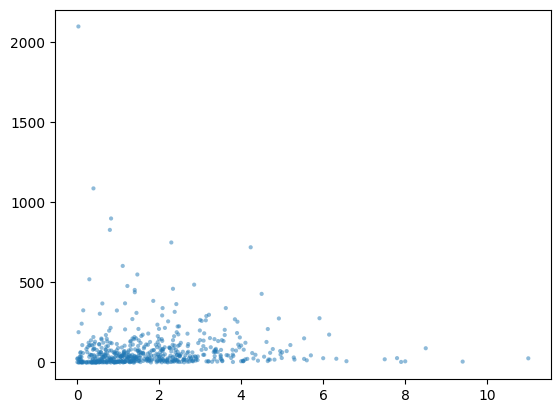

In [11]:
plt.scatter(redshift[mask], T90[mask], 
            marker=".", color='C0', 
            alpha=0.5, edgecolors='None')

print(redshift[mask].shape)

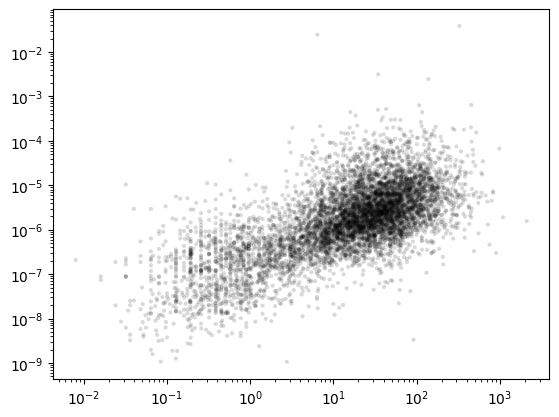

In [18]:
fluence = np.array(data[9], dtype = float)
T90 = np.array(data[6],dtype=float)

mask = np.logical_and(fluence>0, T90>0)
T90 = T90[mask]
fluence = fluence[mask]

plt.scatter(T90, fluence, 
            marker=".", color='black', 
            alpha=0.15, edgecolors='None')
plt.loglog();

In [19]:
X = np.column_stack((T90,fluence))
X = np.log(X)
print(X)

[[  2.27500833 -13.83974178]
 [  4.71626423 -12.82225878]
 [ -1.36257783 -15.13519355]
 ...
 [  1.1429481  -17.5100862 ]
 [  5.34030348 -15.61671449]
 [  1.64557696 -12.85788596]]


## Function plot

In [141]:
def plot_map(X, s):
    # Make some plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()

    # Compute a 2D histogram  of the input
    H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

    # plot density
    ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
              extent=[xedges[0], xedges[-1],
                      yedges[0], yedges[-1]],
              cmap='Blues')

    # plot cluster centers
    if s =='clf':
        cluster_centers = clf.cluster_centers_
    elif s =='ms':
        cluster_centers = ms.cluster_centers_
    else:
        print(s)
        print('invalid input')
        return 0 
    
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
               s=40, c='w', edgecolors='k')

    # plot cluster boundaries
    x_centers = 0.5 * (xedges[1:] + xedges[:-1])
    y_centers = 0.5 * (yedges[1:] + yedges[:-1])

    Xgrid = np.meshgrid(x_centers, y_centers)
    Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

    if s =='clf':
        H = clf.predict(Xgrid).reshape((50, 50))
    elif s =='ms':
        H = ms.predict(Xgrid).reshape((50, 50))

    for i in range(n_clusters):
        Hcp = H.copy()
        flag = (Hcp == i)
        Hcp[flag] = 1
        Hcp[~flag] = 0

        ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
                   linewidths=1, colors='k')

    if s =='clf':
        H = clf.predict(Xgrid).reshape((50, 50))
    elif s =='ms':
        H = ms.predict(Xgrid).reshape((50, 50))
        

    ax.set_xlim(xedges[0], xedges[-1])
    ax.set_ylim(yedges[0], yedges[-1])

    ax.set_xlabel('Eigenvalue 1')
    ax.set_ylabel('Eigenvalue 2')
    
    plt.show()

# Kmeans

/home/sam/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clustering output')

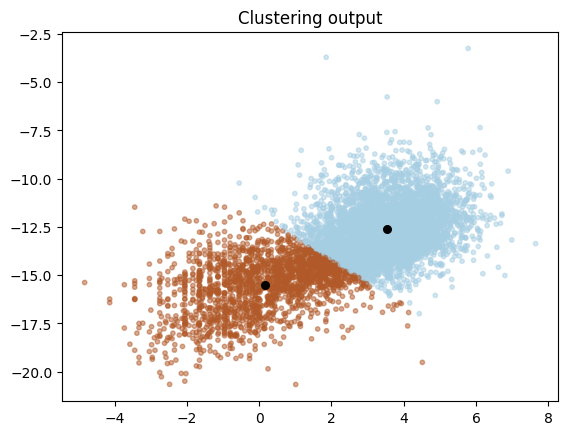

In [145]:
from sklearn.cluster import KMeans

n_clusters=2

clf = KMeans(n_clusters) #Try 2 clusters to start with
clf.fit(X)

centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

plt.scatter(X[:, 0], X[:, 1], 
            c=labels, cmap = 'Paired', s = 10, alpha = .5)

plt.scatter(centers[0, 0], centers[0,1], 
            c='black', s = 30)
plt.scatter(centers[1,0], centers[1,1], 
            c='black', s = 30)

# KMeans?
# help(clf)
plt.title('Clustering output')

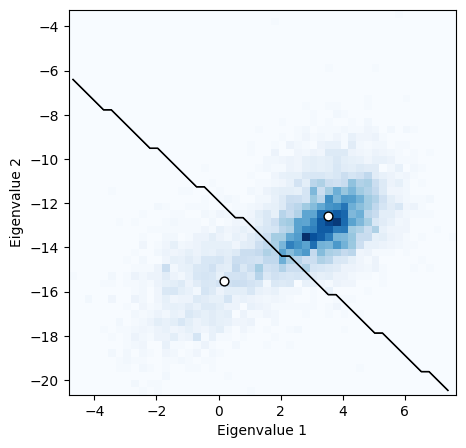

In [146]:
plot_map(X,'clf')

# Meanshift

In [75]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X) # this takes a long time...beware
print(bandwidth)

2.1158614643466183


In [76]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

#scaler = preprocessing.StandardScaler() #normalizes output

#now you don't have to specify the number of clusters!
#bandwidth = 2
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)

ms.fit(X)

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1  2]
2.1158614643466183
number of estimated clusters : 3


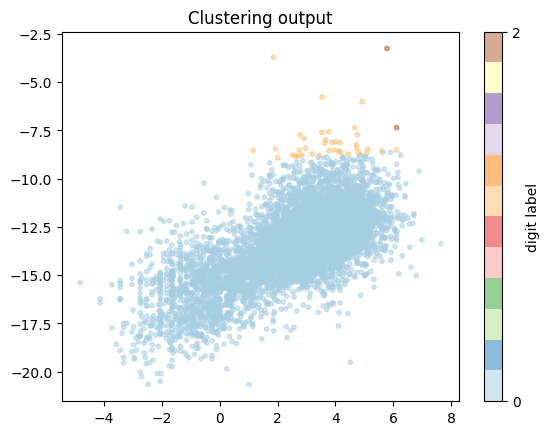

In [77]:
p = ms.predict(X)

plt.scatter(X[:, 0], X[:, 1], 
            c=p, cmap='Paired', s = 10, alpha = .5)

plt.title('Clustering output')
plt.colorbar(label = 'digit label', ticks = range(0, n_clusters, 2));

In [102]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1  2]
2.1158614643466183
number of estimated clusters : 3


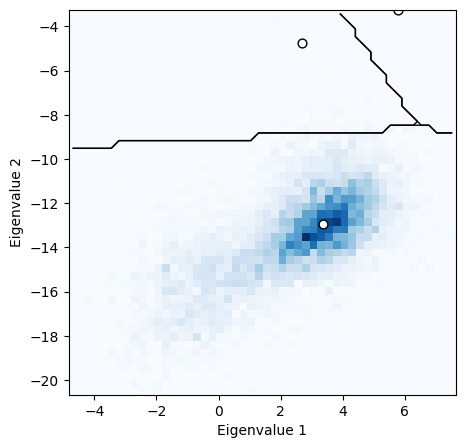

In [143]:
plot_map(X,'ms')

1. The distribution contains **21 different populations of GRBs**
2. ??
3. Are all GRBs more likely to be observed? No, there is a clear preference, the most common one has a flux of intensity $10^{-12}-10^{-14}$ and a duration of the burst of $2-4$ seconds

### If you try two clustering methods, do you get more or less the same?
Let's use Kfold and Mean Shift. We already have our result for ms, let's adjust the number of clusters with the optimal one for Kmeans

/home/sam/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clustering output')

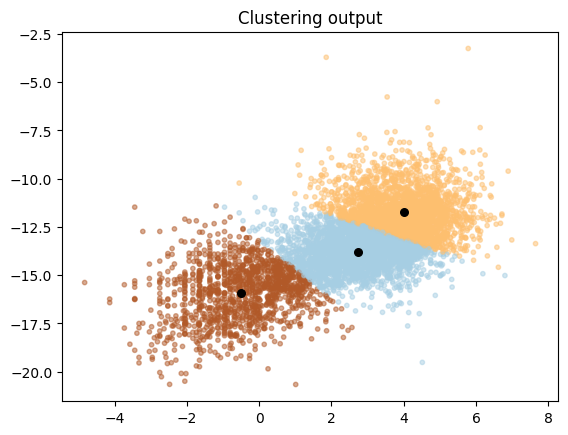

In [108]:
from sklearn.cluster import KMeans

n_clusters=3

clf = KMeans(n_clusters) #Try 2 clusters to start with
clf.fit(X)

centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

plt.scatter(X[:, 0], X[:, 1], 
            c=labels, cmap = 'Paired', s = 10, alpha = .5)

plt.scatter(centers[:, 0], centers[:,1], 
            c='black', s = 30)

# KMeans?
# help(clf)
plt.title('Clustering output')

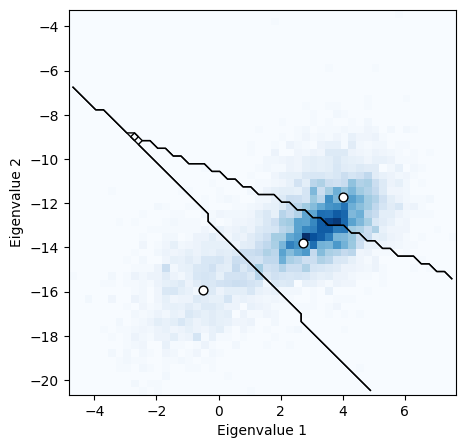

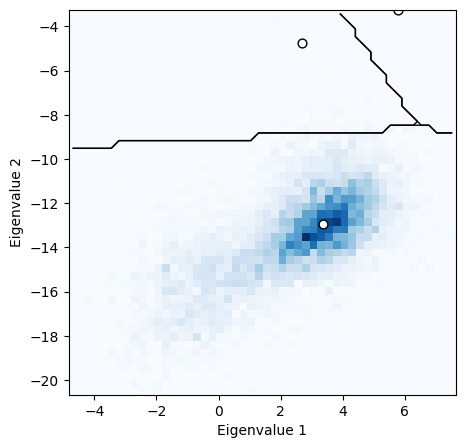

In [144]:
plot_map(X,'clf')
plot_map(X,'ms')

The two methods are very different, ms seems to perform a lot worse

# Which variables show multimodality?


In [152]:
fluence = np.array(data[9], dtype = float)
T100 = np.array(data[12],dtype=float)

mask = np.logical_and(fluence>0, T100>0)
T100 = T100[mask]
fluence = fluence[mask]

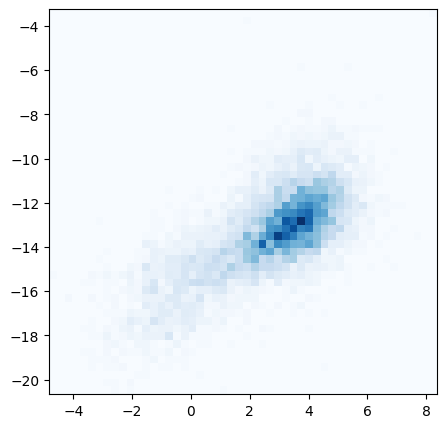

In [155]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

X = np.column_stack((T100,fluence))
X = np.log(X)

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues');